In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.quantization
import cv2
import numpy as np
import os
import glob
from torchvision.models import mobilenet_v3_large
from timm import create_model
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [78]:
class HybridEncoder(nn.Module):
    def __init__(self, embed_dim=256):
        super(HybridEncoder, self).__init__()
        
        # Load MobileNetV3 as feature extractor
        self.mobilenet = mobilenet_v3_large(weights="IMAGENET1K_V1")
        self.mobilenet = nn.Sequential(*list(self.mobilenet.children())[:-1])  # Remove classifier
        
        # MobileViT as lightweight transformer-based feature extractor
        self.mobilevit = create_model("mobilevit_s", pretrained=True)
        self.mobilevit_features = nn.Sequential(*list(self.mobilevit.children())[:-1])  # Remove classifier
        
        # Get feature dimensions
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 256, 256)
            mobilenet_out = self.mobilenet(dummy_input)
            mobilevit_out = self.mobilevit_features(dummy_input)
            mobilenet_channels = mobilenet_out.shape[1]
            mobilevit_channels = mobilevit_out.shape[1]
        
        # Fusion Layer
        self.fusion = nn.Conv2d(mobilenet_channels + mobilevit_channels, embed_dim, kernel_size=1)
        
    def forward(self, x):
        x1 = self.mobilenet(x)  # Extract CNN features
        x2 = self.mobilevit_features(x)  # Extract transformer features
        
        # Resize feature maps to match dimensions
        if x1.shape[2:] != x2.shape[2:]:
            x1 = nn.functional.interpolate(x1, size=x2.shape[2:], mode='bilinear', align_corners=False)
        
        # Concatenate & fuse features
        x = torch.cat([x1, x2], dim=1)
        x = self.fusion(x)
        
        return x

class BathroomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.rgb_images = sorted(glob.glob(os.path.join(root_dir, "*.jpg")))
        self.depth_images = sorted(glob.glob(os.path.join(root_dir, "*.png")))
        
        # Ensure equal number of RGB and depth images
        assert len(self.rgb_images) == len(self.depth_images), "Mismatched number of RGB and depth images"
        
        # Print first few paths to verify
        print(f"First 3 RGB images: {self.rgb_images[:3]}")
        print(f"First 3 depth images: {self.depth_images[:3]}")
    
    def __len__(self):
        return len(self.rgb_images)
    
    def __getitem__(self, idx):
        rgb_path = self.rgb_images[idx]
        depth_path = self.depth_images[idx]
        
        rgb_image = cv2.imread(rgb_path)
        if rgb_image is None:
            raise ValueError(f"Could not read RGB image at {rgb_path}")
        rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
        
        depth_image = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE)
        if depth_image is None:
            raise ValueError(f"Could not read depth image at {depth_path}")
        
        if self.transform:
            rgb_image = self.transform(rgb_image)
            depth_image = transforms.ToTensor()(depth_image)  # Convert to tensor
        
        return rgb_image, depth_image

# Define transforms separately to avoid potential issues
rgb_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),  # Resize to common size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

class SIREN(nn.Module):
    def __init__(self, in_features, out_features, omega=30):
        super(SIREN, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.omega = omega
        
        # Initialize weights according to SIREN paper
        with torch.no_grad():
            self.linear.weight.uniform_(-1/in_features, 1/in_features)
    
    def forward(self, x):
        return torch.sin(self.omega * self.linear(x))

class DynamicSparseAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=8, sparsity_ratio=0.5):
        super(DynamicSparseAttention, self).__init__()
        self.mha = nn.MultiheadAttention(embed_dim, num_heads)
        self.sparsity_ratio = sparsity_ratio
    
    def forward(self, x):
        # Convert input to expected format for MultiheadAttention
        # Expected shape: (seq_len, batch, embed_dim)
        if len(x.shape) == 3:
            # If x is (batch, seq_len, embed_dim)
            x = x.permute(1, 0, 2)
        
        # Compute attention
        attn_output, attn_weights = self.mha(x, x, x)
        
        # Apply sparsity mask
        if self.sparsity_ratio < 1.0:
            mask = torch.zeros_like(attn_weights, dtype=torch.bool)
            values, _ = torch.sort(attn_weights.flatten(1), dim=1, descending=True)
            threshold_idx = int(values.shape[1] * self.sparsity_ratio)
            thresholds = values[:, threshold_idx:threshold_idx+1]
            mask = attn_weights < thresholds.view(-1, 1, 1)
            attn_weights = attn_weights.masked_fill(mask, 0.0)
        
        # Return to original format
        return attn_output.permute(1, 0, 2) if len(x.shape) == 3 else attn_output

class DepthEstimationModel(nn.Module):
    def __init__(self, embed_dim=256):
        super(DepthEstimationModel, self).__init__()
        self.encoder = HybridEncoder(embed_dim)
        
        # Feature processing module
        self.process_features = nn.Sequential(
            nn.Conv2d(embed_dim, embed_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(inplace=True)
        )
        
        # SIREN module for non-linear feature transformation
        self.siren_module = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            SIREN(embed_dim, embed_dim)
        )
        
        # Spatial attention module
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(embed_dim, embed_dim // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(embed_dim // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(embed_dim // 2, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
        # Decoder with skip connections
        self.decoder = nn.Sequential(
            nn.Conv2d(embed_dim + embed_dim, embed_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(embed_dim, embed_dim // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(embed_dim // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(embed_dim // 2, 1, kernel_size=1)
        )
        
    def forward(self, x):
        # Get features from encoder
        features = self.encoder(x)
        processed_features = self.process_features(features)
        
        # Apply SIREN for non-linear transformation
        siren_features = self.siren_module(processed_features)
        siren_features = siren_features.unsqueeze(2).unsqueeze(3).expand(-1, -1, *processed_features.shape[2:])
        
        # Apply spatial attention
        attention_map = self.spatial_attention(processed_features)
        attended_features = processed_features * attention_map
        
        # Combine features and predict depth
        combined_features = torch.cat([attended_features, siren_features], dim=1)
        depth_map = self.decoder(combined_features)
        
        return depth_map

def train_model(model, dataloader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.L1Loss()  # L1 loss is often better for depth estimation
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    
    print(f"Training on device: {device}")
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for i, (images, depths) in enumerate(dataloader):
            images, depths = images.to(device), depths.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            
            # Ensure depths has correct shape and size
            depths = depths.unsqueeze(1) if depths.dim() == 3 else depths
            if outputs.shape[2:] != depths.shape[2:]:
                depths = nn.functional.interpolate(depths, size=outputs.shape[2:], mode='bilinear', align_corners=False)
            
            # Compute loss
            loss = criterion(outputs, depths)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if (i+1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")
        
        avg_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")
        
        # Update learning rate based on validation loss
        scheduler.step(avg_loss)
        
        # Save checkpoint
        if (epoch+1) % 5 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, f'depth_model_checkpoint_epoch_{epoch+1}.pth')
    
    print("Training complete!")
    return model

def evaluate_model(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    criterion = nn.L1Loss()
    
    total_loss = 0.0
    with torch.no_grad():
        for images, depths in dataloader:
            images, depths = images.to(device), depths.to(device)
            outputs = model(images)
            
            # Ensure depths has correct shape and size
            depths = depths.unsqueeze(1) if depths.dim() == 3 else depths
            if outputs.shape[2:] != depths.shape[2:]:
                depths = nn.functional.interpolate(depths, size=outputs.shape[2:], mode='bilinear', align_corners=False)
            
            loss = criterion(outputs, depths)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    print(f"Evaluation Loss: {avg_loss:.4f}")
    return avg_loss

# Example usage
if __name__ == "__main__":
    # Create dataset and dataloaders
    dataset = BathroomDataset(root_dir="bathroom", transform=rgb_transform)
    
    # Split dataset into train/val
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    
    # Use 0 workers to debug DataLoader issues and avoid multiprocessing problems
    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)
    
    # Initialize model
    model = DepthEstimationModel()
    
    # Train model
    trained_model = train_model(model, train_dataloader, epochs=20, lr=0.001)
    
    # Evaluate model
    evaluate_model(trained_model, val_dataloader)
    
    # Save final model
    torch.save(trained_model.state_dict(), 'depth_estimation_model_final.pth')
    print("Model saved successfully!")

First 3 RGB images: ['bathroom\\1.jpg', 'bathroom\\10.jpg', 'bathroom\\11.jpg']
First 3 depth images: ['bathroom\\1.png', 'bathroom\\10.png', 'bathroom\\11.png']
Training samples: 72
Validation samples: 18
Training on device: cpu
Epoch [1/20], Batch [10/18], Loss: 0.2702
Epoch [1/20], Average Loss: 0.3596
Epoch [2/20], Batch [10/18], Loss: 0.0545
Epoch [2/20], Average Loss: 0.0729
Epoch [3/20], Batch [10/18], Loss: 0.0674
Epoch [3/20], Average Loss: 0.0472
Epoch [4/20], Batch [10/18], Loss: 0.0368
Epoch [4/20], Average Loss: 0.0352
Epoch [5/20], Batch [10/18], Loss: 0.0284
Epoch [5/20], Average Loss: 0.0361
Epoch [6/20], Batch [10/18], Loss: 0.0562
Epoch [6/20], Average Loss: 0.0369
Epoch [7/20], Batch [10/18], Loss: 0.0265
Epoch [7/20], Average Loss: 0.0284
Epoch [8/20], Batch [10/18], Loss: 0.0244
Epoch [8/20], Average Loss: 0.0270
Epoch [9/20], Batch [10/18], Loss: 0.0206
Epoch [9/20], Average Loss: 0.0245
Epoch [10/20], Batch [10/18], Loss: 0.0199
Epoch [10/20], Average Loss: 0.024

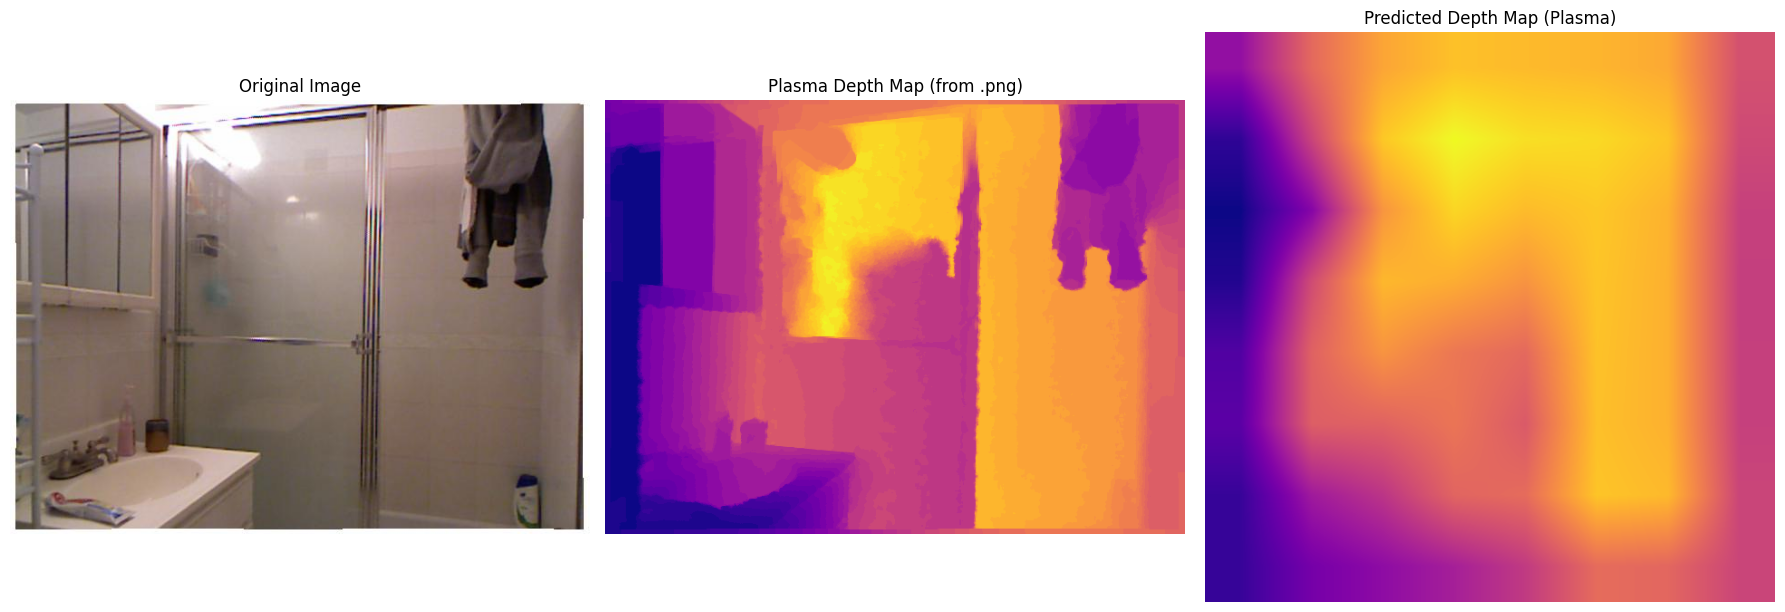

In [79]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob
from torchvision import transforms
from PIL import Image

# Load trained model
model = DepthEstimationModel()
model.load_state_dict(torch.load("depth_estimation_model_final.pth", map_location=torch.device("cpu")))
model.eval()

# Image preprocessing
# rgb_transform = transforms.Compose([
#     transforms.Resize((256, 256)),  # Higher resolution
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
rgb_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Match the output resolution
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),  # Denoise image
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def preprocess_image(image_path):
    """Preprocess an input RGB image for model inference."""
    image = Image.open(image_path).convert("RGB")
    return rgb_transform(image).unsqueeze(0)  # Add batch dimension

def predict_depth(image_path, model):
    """Generate depth map from an input image using the trained model."""
    image_tensor = preprocess_image(image_path)

    # Move to appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    image_tensor = image_tensor.to(device)

    # Generate depth map
    with torch.no_grad():
        depth_map = model(image_tensor)
        depth_map = torch.nn.functional.interpolate(depth_map, size=(512, 512), mode="bilinear", align_corners=False)

    # Convert to numpy and normalize
    depth_map = depth_map.squeeze().cpu().numpy()
    depth_min, depth_max = depth_map.min(), depth_map.max()
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)  # Normalize

    return depth_map

def visualize_comparison(original_path, depth_path, model, figsize=(18, 6), colormap='plasma', save_path=None):
    """
    Displays:
    1. Original RGB Image
    2. Plasma Depth Map (from .png file)
    3. Predicted Depth Map (from model, converted to plasma)
    """
    # Load images
    original = cv2.imread(original_path)
    depth = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE)

    if original is None or depth is None:
        raise ValueError(f"Could not read one or both images: {original_path}, {depth_path}")

    # Convert BGR to RGB
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    # Normalize depth image from .png file
    depth_min, depth_max = depth.min(), depth.max()
    depth_norm = (depth - depth_min) / (depth_max - depth_min) if depth_max > depth_min else depth

    # Convert to plasma colormap
    plasma_depth_map = plt.get_cmap(colormap)(depth_norm)[:, :, :3]  # Remove alpha channel

    # Get model-predicted depth map
    predicted_depth_map = predict_depth(original_path, model)
    predicted_colored = plt.get_cmap(colormap)(predicted_depth_map)[:, :, :3]  # Apply colormap

    # Plot all three images side by side
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    axes[0].imshow(original_rgb)
    axes[0].set_title("Original Image")

    axes[1].imshow(plasma_depth_map)
    axes[1].set_title("Plasma Depth Map (from .png)")

    axes[2].imshow(predicted_colored)
    axes[2].set_title("Predicted Depth Map (Plasma)")

    for ax in axes:
        ax.axis("off")

    plt.tight_layout()

    # Save the visualization
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved visualization: {save_path}")

    plt.show()
    return fig

# Example usage
if __name__ == "__main__":
    image_path = "bathroom/69.jpg"  # Original RGB image
    depth_path = "bathroom/69.png"  # Depth map (ground truth)

    visualize_comparison(image_path, depth_path, model, colormap="plasma")


In [80]:
def get_depth_matrices(original_path, depth_path, model):
    """
    Returns two matrices:
    1. Ground truth depth matrix (from depth image file, normalized 0 to 1).
    2. Predicted depth matrix (from model, normalized 0 to 1).
    """
    # Load and process ground truth depth image
    depth = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE)
    if depth is None:
        raise ValueError(f"Could not read depth image: {depth_path}")
    depth=cv2.resize(depth, (512, 512))
    # Normalize depth image
    depth_min, depth_max = depth.min(), depth.max()
    depth_norm = (depth - depth_min) / (depth_max - depth_min) if depth_max > depth_min else depth

    # Get predicted depth map
    predicted_depth_map = predict_depth(original_path, model)

    return depth_norm, predicted_depth_map

# Example usage
if __name__ == "__main__":
    image_path = "bathroom/1.jpg"
    depth_path = "bathroom/1.png"
    
    true_depth, predicted_depth = get_depth_matrices(image_path, depth_path, model)

    print("True Depth Map Matrix (Normalized):", true_depth.shape)
    print("Predicted Depth Map Matrix (Normalized):", predicted_depth.shape)
    print("Depth Range (True):", true_depth.min(), true_depth.max())
    print("Depth Range (Predicted):", predicted_depth.min(), predicted_depth.max())
    print("Sample True Depth Matrix:")
    print(true_depth)   
    print("Sample Predicted Depth Matrix:") 
    print(predicted_depth)
    error = np.abs(true_depth - predicted_depth)
    print("Mean Absolute Error:", error.mean())


True Depth Map Matrix (Normalized): (512, 512)
Predicted Depth Map Matrix (Normalized): (512, 512)
Depth Range (True): 0.0 1.0
Depth Range (Predicted): 0.0 1.0
Sample True Depth Matrix:
[[0.21052632 0.21052632 0.21052632 ... 0.44736842 0.44736842 0.44736842]
 [0.21052632 0.21052632 0.21052632 ... 0.44736842 0.44736842 0.44736842]
 [0.21052632 0.21052632 0.21052632 ... 0.44736842 0.44736842 0.44736842]
 ...
 [0.02631579 0.02631579 0.02631579 ... 0.60526316 0.60526316 0.60526316]
 [0.02631579 0.02631579 0.02631579 ... 0.60526316 0.60526316 0.60526316]
 [0.02631579 0.02631579 0.02631579 ... 0.60526316 0.60526316 0.60526316]]
Sample Predicted Depth Matrix:
[[0.27916136 0.27916136 0.27916136 ... 0.4984274  0.4984274  0.4984274 ]
 [0.27916136 0.27916136 0.27916136 ... 0.4984274  0.4984274  0.4984274 ]
 [0.27916136 0.27916136 0.27916136 ... 0.4984274  0.4984274  0.4984274 ]
 ...
 [0.         0.         0.         ... 0.58016473 0.58016473 0.58016473]
 [0.         0.         0.         ... 0.5